In [ ]:
# Load Libraries 
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
from keras.utils.vis_utils import plot_model
np.random.seed(0)   
tf.random.set_seed(0)

In [ ]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1] 
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [ ]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270_Data.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()}) 
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(),'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt', 'C_filt','Time','V_filt','SS']]
df_SS = df[['freqQAmpI_filt','C_filt','SS']] 
df_V = df[['freqQAmpI_filt','C_filt','V_filt']] 
df_A = df[['freqQAmpI_filt','C_filt','freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','V_filt']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
         freqQAmpI_filt       C_filt
0         31453.223522  5490.232850
1         31438.277060  5490.239343
2         31421.341616  5490.240838
3         31409.798761  5490.232728
4         31398.815589  5490.222463
...                ...          ...
132394    31055.686766  5457.051859
132395    31041.955345  5457.082380
132396    31035.059531  5457.111463
132397    31020.001291  5457.126443
132398    31012.016780  5457.151945

[132399 rows x 2 columns]
Target Data:
               SS    V_filt
0       5.656166  1.201004
1       5.657157  1.243144
2       5.658317  1.264215
3       5.659499  1.243144
4       5.660404  1.222074
...          ...       ...
132394  5.471059  1.285285
132395  5.474545  0.948161
132396  5.478286  1.158863
132397  5.481751  1.201004
132398  5.484813  0.526756

[132399 rows x 2 columns]


In [ ]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_V = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, ydf_A = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, ydf_WV = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (V), Y = ', np.shape(ydf_V))

# Reshape 
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (132099, 300, 2)
Target shape (SS), Y =  (132099,)
Target shape (V), Y =  (132099,)
After reshaping, X =  (132099, 600)


In [ ]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (V)
x_train, x_test, y_train_V, y_test_V = train_test_split(xdf, ydf_V, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_V, Y_val_V = train_test_split(x_train, y_train_V, test_size=0.125, shuffle=False)

# Select Train
X_train = X_train[13210:92469] 
Y_train_SS = Y_train_SS[13210:92469]
Y_train_V = Y_train_V[13210:92469]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 79259
Validation samples: 13210
Testing samples: 26420


In [ ]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [ ]:
# Normalize the output: V
scaler_v = MinMaxScaler()
Y_train_V = pd.DataFrame(scaler_v.fit_transform(Y_train_V.reshape(-1, 1)))
Y_val_V = pd.DataFrame(scaler_v.transform(Y_val_V.reshape(-1, 1)))
y_test_V = pd.DataFrame(scaler_v.transform(y_test_V.reshape(-1, 1)))

**Define Data-Driven Model**

In [ ]:
# Define DD
def MLP_Data():

  # Define inputs
  X_train = layers.Input(shape=(600),name='X_train')    

  # Prediction: Shear Stress + Slip Rate
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)
  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  v_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  model = keras.Model(inputs=[X_train],outputs=[ss_pred,v_pred])
  return model

In [ ]:
# Model Summary
model=MLP_Data()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_train (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          76928       ['X_train[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 32)           2080        ['dense_1[0][0]']                
                                                                                              

Train on 79259 samples, validate on 13210 samples
Epoch 1/100
78784/79259 [============================>.] - ETA: 0s - loss: 0.0338 - dense_5_loss: 0.0245 - dense_6_loss: 0.0093 - dense_5_mse: 0.0245 - dense_6_mse: 0.0093

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.01831, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


79259/79259 [==============================] - 11s 138us/sample - loss: 0.0337 - dense_5_loss: 0.0244 - dense_6_loss: 0.0093 - dense_5_mse: 0.0244 - dense_6_mse: 0.0093 - val_loss: 0.0183 - val_dense_5_loss: 0.0046 - val_dense_6_loss: 0.0137 - val_dense_5_mse: 0.0046 - val_dense_6_mse: 0.0137
Epoch 2/100
78752/79259 [============================>.] - ETA: 0s - loss: 0.0109 - dense_5_loss: 0.0038 - dense_6_loss: 0.0071 - dense_5_mse: 0.0038 - dense_6_mse: 0.0071
Epoch 2: val_loss improved from 0.01831 to 0.01229, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


79259/79259 [==============================] - 9s 116us/sample - loss: 0.0109 - dense_5_loss: 0.0038 - dense_6_loss: 0.0071 - dense_5_mse: 0.0038 - dense_6_mse: 0.0071 - val_loss: 0.0123 - val_dense_5_loss: 0.0032 - val_dense_6_loss: 0.0091 - val_dense_5_mse: 0.0032 - val_dense_6_mse: 0.0091
Epoch 3/100
78656/79259 [============================>.] - ETA: 0s - loss: 0.0080 - dense_5_loss: 0.0029 - dense_6_loss: 0.0050 - dense_5_mse: 0.0029 - dense_6_mse: 0.0050
Epoch 3: val_loss improved from 0.01229 to 0.00720, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


79259/79259 [==============================] - 9s 114us/sample - loss: 0.0080 - dense_5_loss: 0.0029 - dense_6_loss: 0.0051 - dense_5_mse: 0.0029 - dense_6_mse: 0.0051 - val_loss: 0.0072 - val_dense_5_loss: 0.0026 - val_dense_6_loss: 0.0046 - val_dense_5_mse: 0.0026 - val_dense_6_mse: 0.0046
Epoch 4/100
78944/79259 [============================>.] - ETA: 0s - loss: 0.0071 - dense_5_loss: 0.0028 - dense_6_loss: 0.0044 - dense_5_mse: 0.0028 - dense_6_mse: 0.0044
Epoch 4: val_loss did not improve from 0.00720
79259/79259 [==============================] - 7s 93us/sample - loss: 0.0071 - dense_5_loss: 0.0028 - dense_6_loss: 0.0044 - dense_5_mse: 0.0028 - dense_6_mse: 0.0044 - val_loss: 0.0128 - val_dense_5_loss: 0.0043 - val_dense_6_loss: 0.0085 - val_dense_5_mse: 0.0043 - val_dense_6_mse: 0.0085
Epoch 5/100
78816/79259 [============================>.] - ETA: 0s - loss: 0.0064 - dense_5_loss: 0.0026 - dense_6_loss: 0.0038 - dense_5_mse: 0.0026 - dense_6_mse: 0.0038
Epoch 5: val_loss improv

79259/79259 [==============================] - 9s 115us/sample - loss: 0.0064 - dense_5_loss: 0.0026 - dense_6_loss: 0.0038 - dense_5_mse: 0.0026 - dense_6_mse: 0.0038 - val_loss: 0.0054 - val_dense_5_loss: 0.0013 - val_dense_6_loss: 0.0041 - val_dense_5_mse: 0.0013 - val_dense_6_mse: 0.0041
Epoch 6/100
79040/79259 [============================>.] - ETA: 0s - loss: 0.0056 - dense_5_loss: 0.0023 - dense_6_loss: 0.0033 - dense_5_mse: 0.0023 - dense_6_mse: 0.0033
Epoch 6: val_loss improved from 0.00541 to 0.00400, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


79259/79259 [==============================] - 9s 111us/sample - loss: 0.0055 - dense_5_loss: 0.0023 - dense_6_loss: 0.0033 - dense_5_mse: 0.0023 - dense_6_mse: 0.0033 - val_loss: 0.0040 - val_dense_5_loss: 0.0017 - val_dense_6_loss: 0.0023 - val_dense_5_mse: 0.0017 - val_dense_6_mse: 0.0023
Epoch 7/100
79232/79259 [============================>.] - ETA: 0s - loss: 0.0056 - dense_5_loss: 0.0022 - dense_6_loss: 0.0034 - dense_5_mse: 0.0022 - dense_6_mse: 0.0034
Epoch 7: val_loss did not improve from 0.00400
79259/79259 [==============================] - 7s 94us/sample - loss: 0.0056 - dense_5_loss: 0.0022 - dense_6_loss: 0.0034 - dense_5_mse: 0.0022 - dense_6_mse: 0.0034 - val_loss: 0.0042 - val_dense_5_loss: 0.0022 - val_dense_6_loss: 0.0020 - val_dense_5_mse: 0.0022 - val_dense_6_mse: 0.0020
Epoch 8/100
78976/79259 [============================>.] - ETA: 0s - loss: 0.0049 - dense_5_loss: 0.0020 - dense_6_loss: 0.0029 - dense_5_mse: 0.0020 - dense_6_mse: 0.0029
Epoch 8: val_loss did no

79259/79259 [==============================] - 11s 140us/sample - loss: 0.0046 - dense_5_loss: 0.0018 - dense_6_loss: 0.0028 - dense_5_mse: 0.0018 - dense_6_mse: 0.0028 - val_loss: 0.0035 - val_dense_5_loss: 0.0012 - val_dense_6_loss: 0.0024 - val_dense_5_mse: 0.0012 - val_dense_6_mse: 0.0024
Epoch 10/100
79232/79259 [============================>.] - ETA: 0s - loss: 0.0047 - dense_5_loss: 0.0019 - dense_6_loss: 0.0028 - dense_5_mse: 0.0019 - dense_6_mse: 0.0028
Epoch 10: val_loss did not improve from 0.00352
79259/79259 [==============================] - 10s 120us/sample - loss: 0.0047 - dense_5_loss: 0.0019 - dense_6_loss: 0.0028 - dense_5_mse: 0.0019 - dense_6_mse: 0.0028 - val_loss: 0.0036 - val_dense_5_loss: 0.0012 - val_dense_6_loss: 0.0024 - val_dense_5_mse: 0.0012 - val_dense_6_mse: 0.0024
Epoch 11/100
79072/79259 [============================>.] - ETA: 0s - loss: 0.0045 - dense_5_loss: 0.0017 - dense_6_loss: 0.0027 - dense_5_mse: 0.0017 - dense_6_mse: 0.0027
Epoch 11: val_loss

79259/79259 [==============================] - 9s 112us/sample - loss: 0.0045 - dense_5_loss: 0.0017 - dense_6_loss: 0.0027 - dense_5_mse: 0.0017 - dense_6_mse: 0.0027 - val_loss: 0.0029 - val_dense_5_loss: 0.0012 - val_dense_6_loss: 0.0017 - val_dense_5_mse: 0.0012 - val_dense_6_mse: 0.0017
Epoch 12/100
79040/79259 [============================>.] - ETA: 0s - loss: 0.0044 - dense_5_loss: 0.0019 - dense_6_loss: 0.0025 - dense_5_mse: 0.0019 - dense_6_mse: 0.0025
Epoch 12: val_loss did not improve from 0.00289
79259/79259 [==============================] - 9s 116us/sample - loss: 0.0044 - dense_5_loss: 0.0019 - dense_6_loss: 0.0025 - dense_5_mse: 0.0019 - dense_6_mse: 0.0025 - val_loss: 0.0043 - val_dense_5_loss: 0.0017 - val_dense_6_loss: 0.0026 - val_dense_5_mse: 0.0017 - val_dense_6_mse: 0.0026
Epoch 13/100
79104/79259 [============================>.] - ETA: 0s - loss: 0.0040 - dense_5_loss: 0.0016 - dense_6_loss: 0.0024 - dense_5_mse: 0.0016 - dense_6_mse: 0.0024
Epoch 13: val_loss d

79259/79259 [==============================] - 9s 111us/sample - loss: 0.0036 - dense_5_loss: 0.0015 - dense_6_loss: 0.0021 - dense_5_mse: 0.0015 - dense_6_mse: 0.0021 - val_loss: 0.0028 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0017 - val_dense_5_mse: 0.0011 - val_dense_6_mse: 0.0017
Epoch 16/100
78848/79259 [============================>.] - ETA: 0s - loss: 0.0037 - dense_5_loss: 0.0015 - dense_6_loss: 0.0022 - dense_5_mse: 0.0015 - dense_6_mse: 0.0022
Epoch 16: val_loss did not improve from 0.00282
79259/79259 [==============================] - 9s 119us/sample - loss: 0.0037 - dense_5_loss: 0.0015 - dense_6_loss: 0.0022 - dense_5_mse: 0.0015 - dense_6_mse: 0.0022 - val_loss: 0.0041 - val_dense_5_loss: 0.0020 - val_dense_6_loss: 0.0022 - val_dense_5_mse: 0.0020 - val_dense_6_mse: 0.0022
Epoch 17/100
79200/79259 [============================>.] - ETA: 0s - loss: 0.0039 - dense_5_loss: 0.0015 - dense_6_loss: 0.0024 - dense_5_mse: 0.0015 - dense_6_mse: 0.0024
Epoch 17: val_loss d

79259/79259 [==============================] - 9s 113us/sample - loss: 0.0037 - dense_5_loss: 0.0015 - dense_6_loss: 0.0022 - dense_5_mse: 0.0015 - dense_6_mse: 0.0022 - val_loss: 0.0028 - val_dense_5_loss: 0.0015 - val_dense_6_loss: 0.0013 - val_dense_5_mse: 0.0015 - val_dense_6_mse: 0.0013
Epoch 20/100
78976/79259 [============================>.] - ETA: 0s - loss: 0.0033 - dense_5_loss: 0.0013 - dense_6_loss: 0.0020 - dense_5_mse: 0.0013 - dense_6_mse: 0.0020
Epoch 20: val_loss did not improve from 0.00282
79259/79259 [==============================] - 10s 124us/sample - loss: 0.0033 - dense_5_loss: 0.0013 - dense_6_loss: 0.0020 - dense_5_mse: 0.0013 - dense_6_mse: 0.0020 - val_loss: 0.0030 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0019 - val_dense_5_mse: 0.0011 - val_dense_6_mse: 0.0019
Epoch 21/100
79072/79259 [============================>.] - ETA: 0s - loss: 0.0035 - dense_5_loss: 0.0014 - dense_6_loss: 0.0022 - dense_5_mse: 0.0014 - dense_6_mse: 0.0022
Epoch 21: val_loss 

79259/79259 [==============================] - 10s 123us/sample - loss: 0.0036 - dense_5_loss: 0.0014 - dense_6_loss: 0.0022 - dense_5_mse: 0.0014 - dense_6_mse: 0.0022 - val_loss: 0.0025 - val_dense_5_loss: 0.0012 - val_dense_6_loss: 0.0014 - val_dense_5_mse: 0.0012 - val_dense_6_mse: 0.0014
Epoch 22/100
78912/79259 [============================>.] - ETA: 0s - loss: 0.0033 - dense_5_loss: 0.0013 - dense_6_loss: 0.0020 - dense_5_mse: 0.0013 - dense_6_mse: 0.0020
Epoch 22: val_loss improved from 0.00252 to 0.00239, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


79259/79259 [==============================] - 9s 120us/sample - loss: 0.0033 - dense_5_loss: 0.0013 - dense_6_loss: 0.0020 - dense_5_mse: 0.0013 - dense_6_mse: 0.0020 - val_loss: 0.0024 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0013 - val_dense_5_mse: 0.0011 - val_dense_6_mse: 0.0013
Epoch 23/100
79040/79259 [============================>.] - ETA: 0s - loss: 0.0030 - dense_5_loss: 0.0012 - dense_6_loss: 0.0018 - dense_5_mse: 0.0012 - dense_6_mse: 0.0018
Epoch 23: val_loss did not improve from 0.00239
79259/79259 [==============================] - 10s 126us/sample - loss: 0.0030 - dense_5_loss: 0.0012 - dense_6_loss: 0.0018 - dense_5_mse: 0.0012 - dense_6_mse: 0.0018 - val_loss: 0.0030 - val_dense_5_loss: 0.0014 - val_dense_6_loss: 0.0017 - val_dense_5_mse: 0.0014 - val_dense_6_mse: 0.0017
Epoch 24/100
78944/79259 [============================>.] - ETA: 0s - loss: 0.0031 - dense_5_loss: 0.0012 - dense_6_loss: 0.0020 - dense_5_mse: 0.0012 - dense_6_mse: 0.0020
Epoch 24: val_loss 

79259/79259 [==============================] - 9s 119us/sample - loss: 0.0027 - dense_5_loss: 0.0010 - dense_6_loss: 0.0016 - dense_5_mse: 0.0010 - dense_6_mse: 0.0016 - val_loss: 0.0019 - val_dense_5_loss: 8.6477e-04 - val_dense_6_loss: 0.0011 - val_dense_5_mse: 8.6470e-04 - val_dense_6_mse: 0.0011
Epoch 29/100
79232/79259 [============================>.] - ETA: 0s - loss: 0.0028 - dense_5_loss: 0.0011 - dense_6_loss: 0.0017 - dense_5_mse: 0.0011 - dense_6_mse: 0.0017
Epoch 29: val_loss did not improve from 0.00194
79259/79259 [==============================] - 10s 121us/sample - loss: 0.0028 - dense_5_loss: 0.0011 - dense_6_loss: 0.0017 - dense_5_mse: 0.0011 - dense_6_mse: 0.0017 - val_loss: 0.0038 - val_dense_5_loss: 0.0012 - val_dense_6_loss: 0.0026 - val_dense_5_mse: 0.0012 - val_dense_6_mse: 0.0026
Epoch 30/100
78688/79259 [============================>.] - ETA: 0s - loss: 0.0027 - dense_5_loss: 0.0011 - dense_6_loss: 0.0017 - dense_5_mse: 0.0011 - dense_6_mse: 0.0017
Epoch 30: v

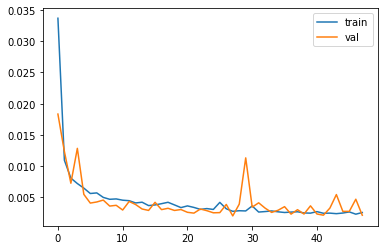

---Training time: 432.14096045 seconds ---


In [ ]:
# Train The Model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto')  
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit([X_train],[Y_train_SS,Y_train_V], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS,Y_val_V]), verbose=1)
end_time = time.time()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [ ]:
# # Save the model
# print(model.summary())
# plot_model(model, show_shapes=True)
# model.save('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/Reference_p5270/Reference/DD_Transfer_model_70_10_20.h5')

In [ ]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)[0,] 
y_predtrain_V =np.array(y_predtrain)[1,] 

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS) 
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS)) 

train_r2_V = r2_score(Y_train_V,y_predtrain_V ) 
train_rmse_V = np.sqrt(mean_squared_error(Y_train_V, y_predtrain_V )) 

# Model Performance: Validation 
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)[0,] 
y_predval_V = np.array(y_predval)[1,] 

val_r2_SS = r2_score(Y_val_SS, y_predval_SS) 
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS)) 

val_r2_V = r2_score(Y_val_V, y_predval_V) 
val_rmse_V = np.sqrt(mean_squared_error(Y_val_V, y_predval_V)) 

# Model Performance: Testing 
y_predtest = model.predict([x_test])
y_predtest_SS =np.array(y_predtest)[0,] 
y_predtest_V = np.array(y_predtest)[1,] 

test_r2_SS = r2_score(y_test_SS,y_predtest_SS) 
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS)) 

test_r2_V = r2_score(y_test_V,y_predtest_V) 
test_rmse_V = np.sqrt(mean_squared_error(y_test_V, y_predtest_V)) 

# Print R2 Results 
print("R2 scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_r2_SS , train_r2_V))
print("R2 scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_r2_SS , val_r2_V))
print("R2 scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_r2_SS , test_r2_V))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_rmse_SS , train_rmse_V))
print("RMSE scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_rmse_SS , val_rmse_V))
print("RMSE scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_rmse_SS , test_rmse_V))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


R2 scores: Train (SS) - 0.98318, Train (V) - 0.93463
R2 scores: Validation (SS) - 0.97236, Validation (V) - 0.91762
R2 scores: Testing (SS) - 0.92502, Testing (V) - 0.90199
RMSE scores: Train (SS) - 0.02177, Train (V) - 0.02471
RMSE scores: Validation (SS) - 0.03182, Validation (V) - 0.03474
RMSE scores: Testing (SS) - 0.05135, Testing (V) - 0.03681


In [ ]:
# Inverse scaling: SS 
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [ ]:
# Inverse scaling: V
Y_train_V = scaler_v.inverse_transform(Y_train_V)
Y_val_V = scaler_v.inverse_transform(Y_val_V)
y_test_V = scaler_v.inverse_transform(y_test_V)
y_predtrain_V = scaler_v.inverse_transform(y_predtrain_V)
y_predval_V = scaler_v.inverse_transform(y_predval_V)
y_predtest_V = scaler_v.inverse_transform(y_predtest_V)

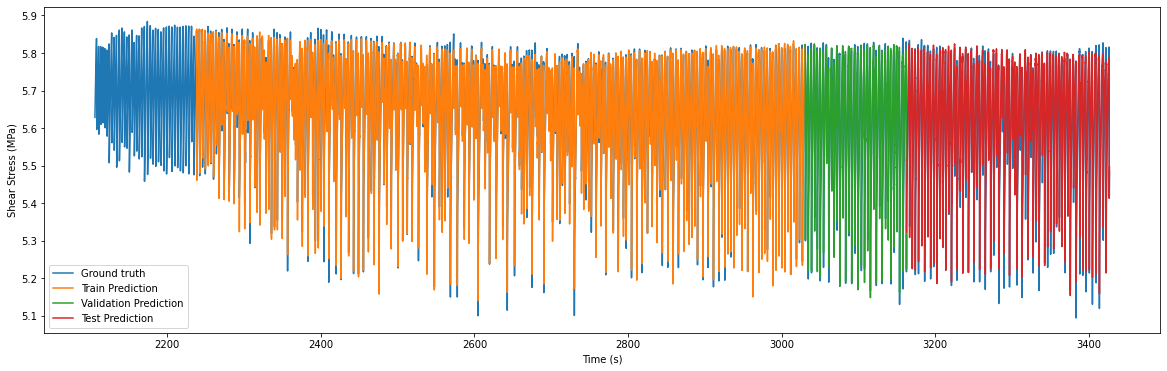

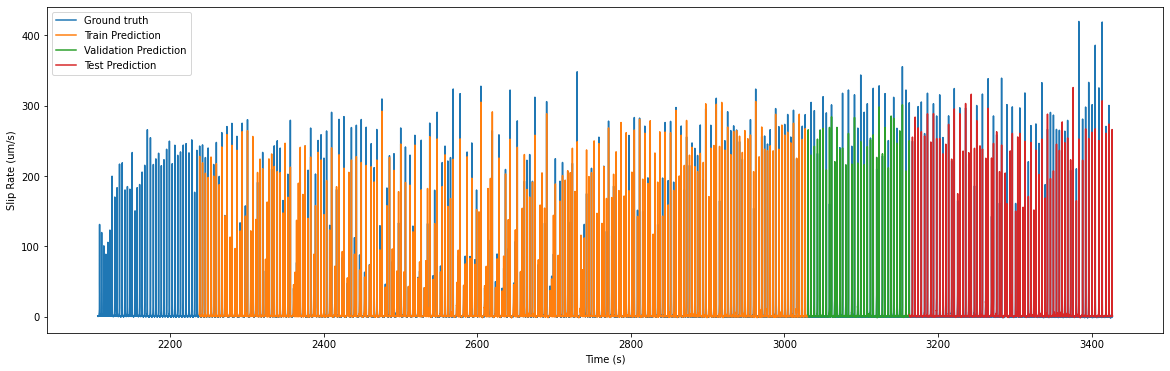

In [ ]:
# Overall plot: SS & V 
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[13210:92469] 

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_V)
plt.plot(traintime, y_predtrain_V)
plt.plot(valtime,  y_predval_V)
plt.plot(testtime, y_predtest_V)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

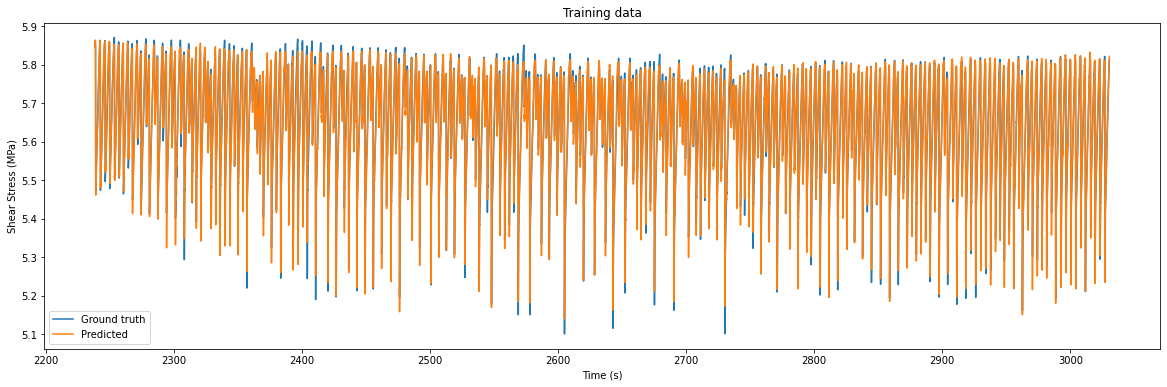

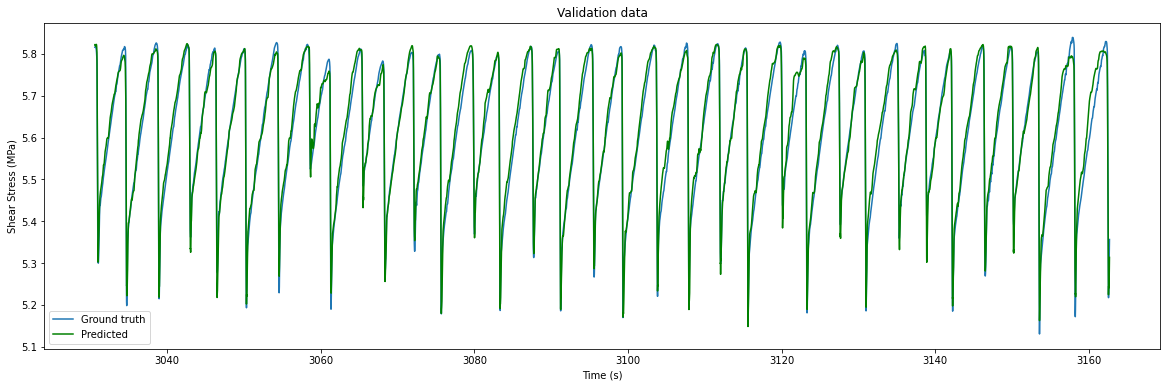

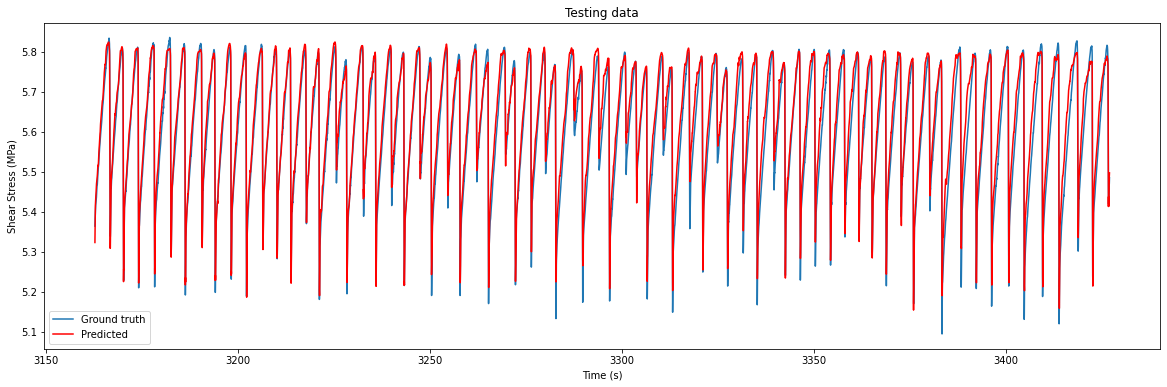

In [ ]:
# Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

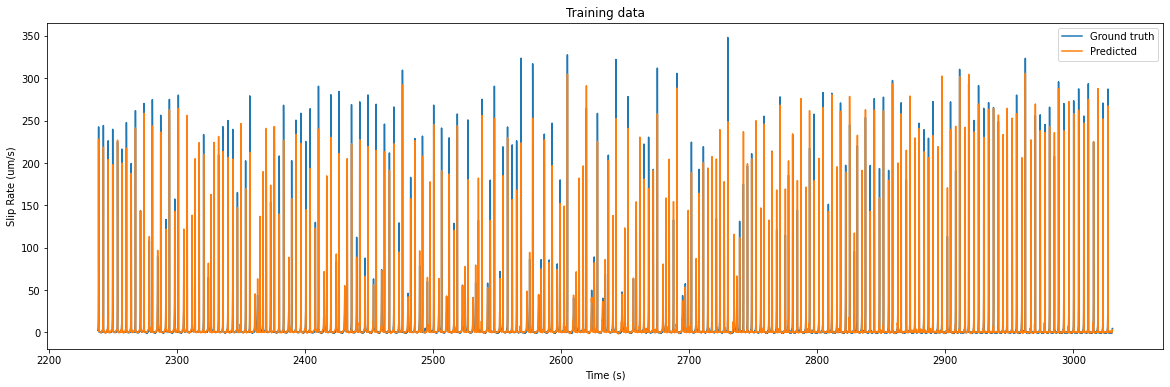

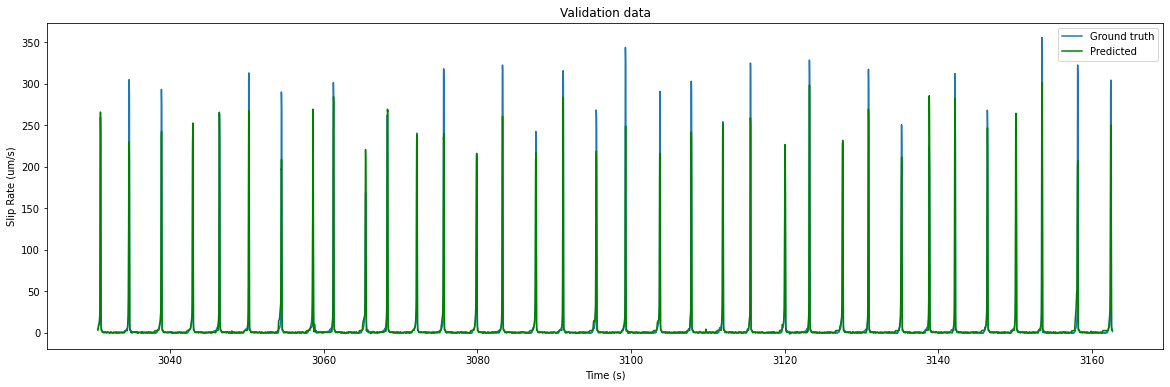

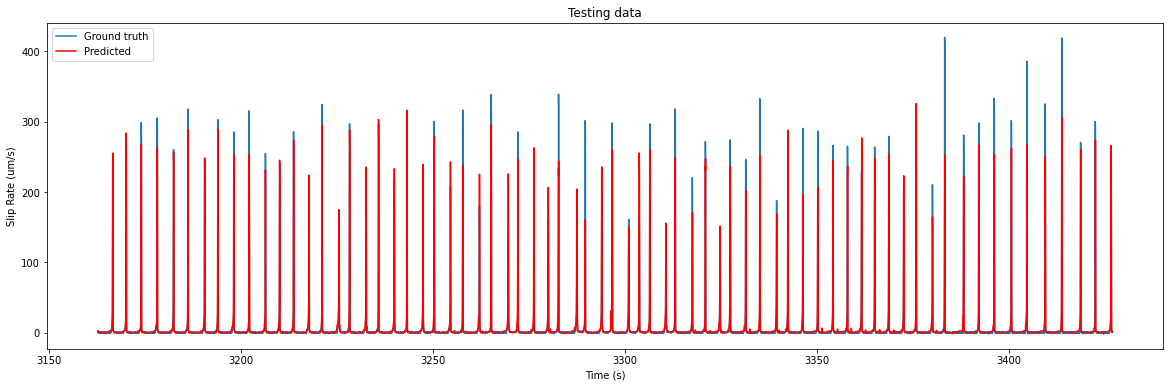

In [ ]:
# Individual plot: V

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_V, y_predtrain_V, 'Training data', '')
results_plot(2, valtime, Y_val_V, y_predval_V, 'Validation data', 'g')
results_plot(3, testtime, y_test_V, y_predtest_V, 'Testing data', 'r')

In [ ]:
# # Extract Data

# # Time 
# savetxt('Whole_time.csv', ttime, delimiter=',')
# savetxt('traintime.csv', traintime, delimiter=',')
# savetxt('valtime.csv', valtime, delimiter=',')
# savetxt('testtime.csv', testtime, delimiter=',')

# # SS
# savetxt('Y_train_SS.csv', Y_train_SS, delimiter=',')
# savetxt('Y_val_SS.csv', Y_val_SS, delimiter=',')
# savetxt('y_test_SS.csv', y_test_SS, delimiter=',')
# savetxt('y_predtrain_SS.csv', y_predtrain_SS, delimiter=',')
# savetxt('y_predval_SS.csv', y_predval_SS, delimiter=',')
# savetxt('y_predtest_SS.csv', y_predtest_SS, delimiter=',')

# # V
# savetxt('Y_train_V.csv', Y_train_V, delimiter=',')
# savetxt('Y_val_V.csv', Y_val_V, delimiter=',')
# savetxt('y_test_V.csv', y_test_V, delimiter=',')
# savetxt('y_predtrain_V.csv', y_predtrain_V, delimiter=',')
# savetxt('y_predval_V.csv', y_predval_V, delimiter=',')
# savetxt('y_predtest_V.csv', y_predtest_V, delimiter=',')

# # Download
# files.download('Whole_time.csv')
# files.download('traintime.csv')
# files.download('valtime.csv')
# files.download('testtime.csv')

# files.download('Y_train_SS.csv')
# files.download('Y_val_SS.csv')
# files.download('y_test_SS.csv')
# files.download('y_predtrain_SS.csv')
# files.download('y_predval_SS.csv')
# files.download('y_predtest_SS.csv')

# files.download('Y_train_V.csv')
# files.download('Y_val_V.csv')
# files.download('y_test_V.csv')
# files.download('y_predtrain_V.csv')
# files.download('y_predval_V.csv')
# files.download('y_predtest_V.csv')